In [1]:
import os
from os import path
import numpy as np
import nibabel as nib
from tqdm import tqdm
from torch.utils.data import Dataset
from glob import glob
import random
import torch
import torchio as tio
import matplotlib.pyplot as plt
from dataset_tio import *
import torchvision
from generator import GeneratorRRDB
from trainer_org import LitTrainer as LitTrainer_org
from trainer_gan import LitTrainer as LitTrainer_gan
# from trainer_tune import LitTrainer as LitTrainer_tune
import pytorch_lightning as pl
from discriminator import Discriminator
from feature_extractor import FeatureExtractor

print(os.getcwd())

/mnt/beta/djboonstoppel/Code


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
std = 0.3548

In [4]:
generator = GeneratorRRDB(channels=1, filters=64, num_res_blocks=1)
# discriminator = Discriminator(input_shape=(1, 64, 64))
feature_extractor = FeatureExtractor()

In [5]:
test_subjects = data_split('test', patients_frac=1)

test_set = tio.SubjectsDataset(
    test_subjects, transform=Normalize(std=std))

Loading test set...


In [27]:
real_subjects = real_data()

transform = tio.Compose([
    Normalize(std=std),
    # tio.CropOrPad((224,224,45))
])

real_set = tio.SubjectsDataset(
    real_subjects, transform=transform)

Loading real dataset...


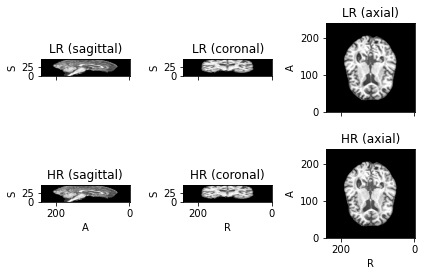

In [23]:
img_real = ImagePair(number=7, simulated=False, select_slices=48)
real_subject = [img_real.subject()]
real_set = tio.SubjectsDataset(
    real_subject, transform=Normalize(std=std))

real_set[0].plot()

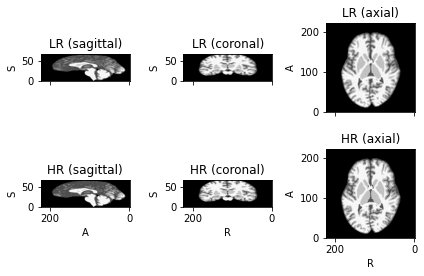

In [49]:
img_sim = ImagePair(number=100206, simulated=True, select_slices=70)
sim_subject = [img_sim.subject()]

sim_set = tio.SubjectsDataset(
    sim_subject, transform=Normalize(std=std))

sim_set[0].plot()

In [62]:
ckptpath='ray_results/alpha_content_parallel/checkpoints'
# exp_name = 'baseline_64-3'

# ckpt_filename = exp_name + '-checkpoint-v2'
ckpt_filename = 'checkpoint_5-best'

model = LitTrainer_org.load_from_checkpoint(netG=generator,
                                            netF=feature_extractor,
                                            # netD=discriminator,
                                            # netF=feature_extractor,
                                            checkpoint_path=os.path.join(ckptpath, ckpt_filename+'.ckpt'))
print(model.hparams)
model.eval()
model.freeze()

"args":   Namespace(std=0.3548, num_workers=4, root_dir='/mnt/beta/djboonstoppel/Code', name='alpha_content_parallel', num_samples=1, patch_size=64, batch_size=256, logger=True, checkpoint_callback=None, enable_checkpointing=True, default_root_dir=None, gradient_clip_val=None, gradient_clip_algorithm=None, process_position=0, num_nodes=1, num_processes=1, devices=None, gpus=None, auto_select_gpus=False, tpu_cores=None, ipus=None, log_gpu_memory=None, progress_bar_refresh_rate=None, enable_progress_bar=True, overfit_batches=0.0, track_grad_norm=-1, check_val_every_n_epoch=1, fast_dev_run=False, accumulate_grad_batches=None, max_epochs=-1, min_epochs=None, max_steps=-1, min_steps=None, max_time='00:24:00:00', limit_train_batches=1.0, limit_val_batches=1.0, limit_test_batches=1.0, limit_predict_batches=1.0, val_check_interval=1.0, flush_logs_every_n_steps=None, log_every_n_steps=50, accelerator=None, strategy=None, sync_batchnorm=False, precision=16, enable_model_summary=True, weights_sum

In [63]:
batch_size = model.hparams.config['batch_size']

patch_size = (model.hparams.config['patch_size'],model.hparams.config['patch_size'])
ovl_perc = (model.hparams.config['patch_overlap'], model.hparams.config['patch_overlap'])
overlap, nr_patches = calculate_overlap(test_subjects[0]['LR'], patch_size, ovl_perc)

In [64]:
subject = sim_set[0]
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size=(*patch_size,1),
    patch_overlap=overlap,
    padding_mode=0,
)

patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=model.hparams.config['batch_size'])

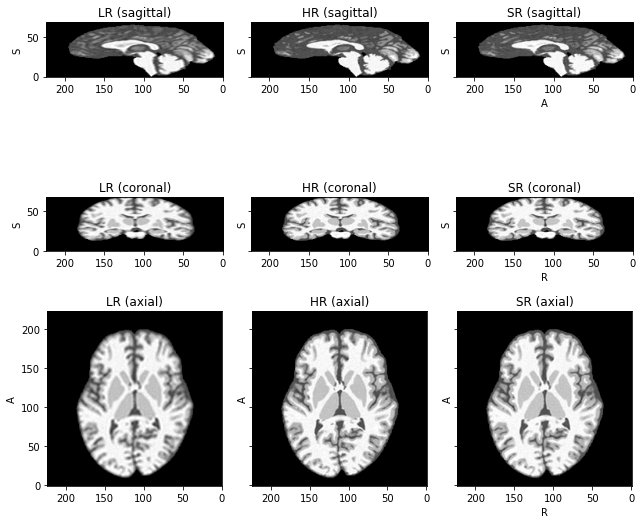

In [65]:
aggregator = tio.inference.GridAggregator(grid_sampler)#, overlap_mode='average')
model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA].squeeze(4), patches_batch['HR'][tio.DATA].squeeze(4)
        gen_hr = model(imgs_lr).unsqueeze(4)
        locations = patches_batch[tio.LOCATION]
        aggregator.add_batch(gen_hr, locations)

foreground = aggregator.get_output_tensor()
generated = tio.ScalarImage(tensor=foreground)
subject.add_image(generated, 'SR')
subject.plot(figsize=(9, 8))


In [66]:
def re_scale(img, std, max_val):
    img *= std
    img *= max_val
    return img

def save_to_nifti(img, header, fname, std, max_val):
    affine = np.eye(4)
    affine[2,2] = 2
    img = img.numpy()[0]
    img = re_scale(img, std, max_val)
    img_nifti = nib.Nifti1Image(img, affine=affine, header=header)
    nib.save(img_nifti, fname)

def save_subject(subject, header, pref, std, max_vals, path='output'):
    save_to_nifti(img = subject['LR'],
                  header = header,
                  std = std,
                  max_val = max_vals[0],
                  fname = os.path.join(path, '{}_LR.nii.gz'.format(pref)),
                  )
    save_to_nifti(img = subject['HR'],
                  header = header,
                  std = std,
                  max_val = max_vals[1],
                  fname = os.path.join(path, '{}_HR.nii.gz'.format(pref)),
                  )
    save_to_nifti(img = subject['SR'],
                  header = header,
                  std = std,
                  max_val = max_vals[2],
                  fname = os.path.join(path, '{}_SR.nii.gz'.format(pref)),
                  )

In [67]:
# gen_hr = subject['SR'].numpy()[0]
# gen_hr_nifty = nib.Nifti1Image(gen_hr, affine=img.subject()['HR'].affine, header=img.info()['HR'])
# nib.save(gen_hr_nifty, 'test.nii.gz')
output_path = 'output/alpha_content'
os.makedirs(output_path, exist_ok=True)
name='100206-500'
std = std
max_vals = (
    img_sim.info()['LR']['scaling'],
    img_sim.info()['HR']['scaling'],
    img_sim.info()['LR']['scaling'],
    )
save_subject(subject=subject,
             header=img_sim.info()['LR']['header'],
             pref=name,
             std=std,
             max_vals=max_vals,
             path=output_path,
             )

In [ ]:
# config = {
#     'learning_rate': 0.0001,
#     'patch_size': 224,
#     'batch_size': 16,
#     'patients_frac': 0.5,
#     'patch_overlap': 0.5,
#     'optimizer': 'adam',
#     'edge_loss': 2,
# }
# ckpt_filename = 'checkpoint_{}_{}_{}_{}_{}_{}'.format(config['patch_size'],
#                                                       config['batch_size'],
#                                                       config['patients_frac'],
#                                                       config['edge_loss'],
#                                                       config['optimizer'],
#                                                       config['learning_rate'],
#                                                       )

config = model.hparams.config
# img_name = 'gen_{}_{}_{}_{}_{}_{}_{}'.format(config['patch_size'],
#                                           config['batch_size'],
#                                           config['patients_frac'],
#                                           config['edge_loss'],
#                                           config['optimizer'],
#                                           # config['learning_rate'],
#                                           config['content'],
#                                           config['adversarial'],
#                                           )

# img_name = 'real_gen_{}'.format(config['patch_size'])
# subject['gen_hr'].save(os.path.join('output', img_name+'_2.dcm'))
# subject['gen_hr'].save(os.path.join('output'))#, img_name+'_2.dcm'))

In [3]:
print(pl.__version__)

1.5.9


In [15]:
import json
dict = {'alpha_content': 0.01,
        'patients_frac': 0.1,
        }

fname = json.dumps(dict)

# fname = "{'alpha_content': 0.01}"
# fname = "{'alpha_content': 0.01, 'patients_frac': 0.1}"

chars = ['"', '{', '}', '. ', '_']

for char in chars:
	fname = fname.replace(char, '')
fname = fname.replace(': ', '_')
fname = fname.replace(', ', '-')
fname = fname.replace('.', ',')



print(fname)

alphacontent_0,01-patientsfrac_0,1


In [11]:
import json
dict = {'alpha_content': 0.01,
        'patients_frac': 0.1,
        }

print(json.dumps(dict))

{"alpha_content": 0.01, "patients_frac": 0.1}
